# Interactive Data Exploration
This notebook is for gaining some preliminary insight into the selected datasets we've chose to investigate. Our tentative
hypothesis is that there exists a largely positive correlation between investment grade corporate bond yields and the
treasury spread.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

from utilities import filterout, normalize

In [57]:
# Read in the data from CSV file
filenames = ["DBAA", "TEDRATE"]

# Store each series in a mapping from filename to dataframe
dfs = {
    fn: pd.read_csv(f"./data/{fn}.csv", parse_dates=["DATE"]) for fn in filenames
}

# Filter out each non-numeric occurence in each series
for key in dfs:
    dfs[key] = filterout(dfs[key], key, ".")
    dfs[key][key] = pd.to_numeric(dfs[key][key])

# Get the intersection of the time series data relative to common dates
date_index = get_common_dates([dfs[key] for key in dfs])
common_date_dfs = {
    fn: dfs[fn][dfs[fn].index.isin(date_index)] for fn in filenames
}

# Set the index of the dataframes to be the dates
for key in common_date_dfs.keys():
    common_date_dfs[key] = common_date_dfs[key].set_index("DATE")
    
# Normalized time series
normalized_series = {
    fn: normalize(common_date_dfs[fn][fn]) for fn in filenames
}

### Visualization of Normalized Time Series 

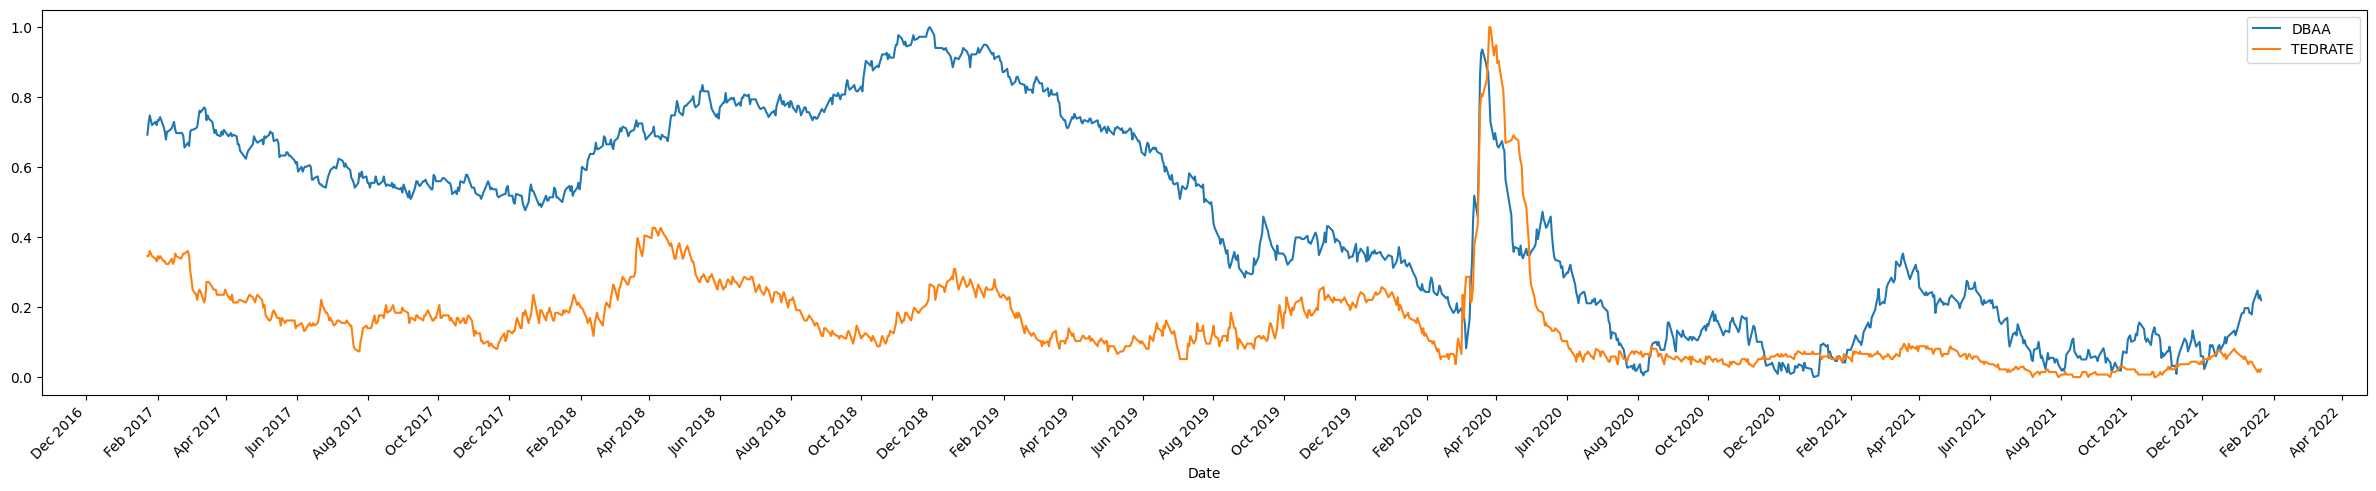

In [67]:
fig, ax = plt.subplots(figsize=(30, 5))
[ax.plot(common_date_dfs[label].index, ns, label=label) for label, ns in normalized_series.items()]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

### Correlation as a Function of Window Length
We have a measure of the correlation between the two realizations of the underlying random variables that represent `DBAA` and `TEDRATE`. There is
largely a positive correlation, but what we seek to investigate now is correlation as a function of window length. Meaning, given some start date
and end date, what is the correlation over that interval.

In [152]:
max_window_size = len(common_date_dfs["DBAA"]["DBAA"].values)
corr_by_window = {ws:[] for ws in range(1, max_window_size + 1)}
window_size = 2

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        dbaa_slice = common_date_dfs["DBAA"]["DBAA"][beg_ndx:end_ndx]
        tedrate_slice = common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        corr_by_window[window_size].append(dbaa_slice.corr(tedrate_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += 1